# Import Packages

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
from keras import backend as K
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")

# Data Loading

**Run this code only one time to make data.csv**

In [2]:
dataframes = []

directory = "raw/phone/accel"

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)
        with open(file_path) as f:
            content = f.read().strip()
            rows = content.split(";")
            rows = [row.split(",") for row in rows]
            df = pd.DataFrame(rows, columns=["user", "activity", "timestamp", "x-axis", "y-axis", "z-axis"])
            dataframes.append(df)

df = pd.concat(dataframes)

In [3]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1600,A,252207666810782,-0.36476135,8.793503,1.0550842
1,\n1600,A,252207717164786,-0.8797302,9.768784,1.0169983
2,\n1600,A,252207767518790,2.0014954,11.10907,2.619156
3,\n1600,A,252207817872794,0.45062256,12.651642,0.18455505
4,\n1600,A,252207868226798,-2.1643524,13.928436,-4.4224854


In [4]:
dataframes2 = []

directory = "raw/phone/gyro"

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)
        with open(file_path) as f:
            content = f.read().strip()
            rows = content.split(";")
            rows = [row.split(",") for row in rows]
            df2 = pd.DataFrame(rows, columns=["user", "activity", "timestamp", "x-axis", "y-axis", "z-axis"])
            dataframes2.append(df2)

df2 = pd.concat(dataframes2)

In [5]:
df2.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1600,A,252207918580802,-0.85321045,0.29722595,0.8901825
1,\n1600,A,252207968934806,-0.8751373,0.015472412,0.16223145
2,\n1600,A,252208019288809,-0.72016907,0.38848877,-0.28401184
3,\n1600,A,252208069642813,-0.57164,1.2274017,-0.2416687
4,\n1600,A,252208119996817,-0.38049316,1.2028351,-0.21313477


In [6]:
dataframes3 = []

directory = "raw/watch/accel"

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)
        with open(file_path) as f:
            content = f.read().strip()
            rows = content.split(";")
            rows = [row.split(",") for row in rows]
            df3 = pd.DataFrame(rows, columns=["user", "activity", "timestamp", "x-axis", "y-axis", "z-axis"])
            dataframes3.append(df3)

df3 = pd.concat(dataframes3)

In [7]:
df3.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1600,A,90426708196641,7.091625,-0.5916671,8.195502
1,\n1600,A,90426757696641,4.972757,-0.15831658,6.6967316
2,\n1600,A,90426807196641,3.25372,-0.19183542,6.107758
3,\n1600,A,90426856696641,2.801216,-0.15592238,5.997625
4,\n1600,A,90426906196641,3.7708676,-1.0513538,7.731027


In [8]:
dataframes4 = []

directory = "raw/watch/gyro"

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)
        with open(file_path) as f:
            content = f.read().strip()
            rows = content.split(";")
            rows = [row.split(",") for row in rows]
            df4 = pd.DataFrame(rows, columns=["user", "activity", "timestamp", "x-axis", "y-axis", "z-axis"])
            dataframes4.append(df4)

df4 = pd.concat(dataframes4)

In [9]:
df4.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1600,A,90426757696641,0.3149441,-1.0222765,-0.3099616
1,\n1600,A,90426807196641,0.3873821,-0.61854124,-0.048971802
2,\n1600,A,90426856696641,0.07099854,-0.20947972,-0.1959783
3,\n1600,A,90426906196641,0.037975345,0.25497556,-0.1565635
4,\n1600,A,90426955696641,0.07312907,0.71943086,-0.0010349044


In [10]:
df_concat = pd.concat([df, df2, df3, df4])

In [11]:
df_concat.to_csv('data.csv')

# EDA

In [12]:
df_concat = pd.read_csv('data.csv')

In [13]:
df_concat = df_concat.head(200000)

In [14]:
df_concat.shape

(200000, 7)

In [15]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  200000 non-null  int64  
 1   user        199998 non-null  float64
 2   activity    199998 non-null  object 
 3   timestamp   199998 non-null  float64
 4   x-axis      199998 non-null  float64
 5   y-axis      199998 non-null  float64
 6   z-axis      199998 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


# Preprocessing of Data for Models

In [16]:
# define the mapping
activity_map = {'A': 'walking', 'B': 'jogging', 'C': 'stairs', 'D': 'sitting', 'E': 'standing',
                'F': 'typing', 'G': 'teeth', 'H': 'soup', 'I': 'chips', 'J': 'pasta', 'K': 'drinking',
                'L': 'sandwich', 'M': 'kicking', 'O': 'catch', 'P': 'dribbling', 'Q': 'writing',
                'R': 'clapping', 'S': 'folding'}

# apply the replace to the column in the dataframe
df_concat['activity'] = df_concat['activity'].replace(activity_map)

# change the data type of each column
#df_concat["timestamp"] = df_concat["timestamp"].astype("float")
df_concat[["x-axis", "y-axis", "z-axis"]] = df_concat[["x-axis", "y-axis", "z-axis"]].astype("float")

In [17]:
df_concat.head()

,Unnamed: 0,user,activity,timestamp,x-axis,y-axis,z-axis
0,0,1600.0,walking,2.522077e+14,-0.364761,8.793503,1.055084
1,1,1600.0,walking,2.522077e+14,-0.879730,9.768784,1.016998
2,2,1600.0,walking,2.522078e+14,2.001495,11.109070,2.619156
3,3,1600.0,walking,2.522078e+14,0.450623,12.651642,0.184555
4,4,1600.0,walking,2.522079e+14,-2.164352,13.928436,-4.422485


In [18]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  200000 non-null  int64  
 1   user        199998 non-null  float64
 2   activity    199998 non-null  object 
 3   timestamp   199998 non-null  float64
 4   x-axis      199998 non-null  float64
 5   y-axis      199998 non-null  float64
 6   z-axis      199998 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


In [19]:
df_concat.isnull().sum()

Unnamed: 0    0
user          2
activity      2
timestamp     2
x-axis        2
y-axis        2
z-axis        2
dtype: int64

In [20]:
data = df_concat.dropna()

In [21]:
data['activity'].value_counts()

soup         17025
pasta        17024
chips        16033
typing       11658
walking      11658
standing     11657
teeth        11656
stairs       11656
jogging      11656
sitting      11655
drinking     11471
writing       8335
catch         8091
sandwich      8087
kicking       8085
dribbling     8085
clapping      8083
folding       8083
Name: activity, dtype: int64

In [22]:
data['x'] = data['x-axis'].astype('float')
data['y'] = data['y-axis'].astype('float')
data['z'] = data['z-axis'].astype('float')

In [23]:
Fs = 20
activities = data['activity'].value_counts().index
activities

Index(['soup', 'pasta', 'chips', 'typing', 'walking', 'standing', 'teeth',
       'stairs', 'jogging', 'sitting', 'drinking', 'writing', 'catch',
       'sandwich', 'kicking', 'dribbling', 'clapping', 'folding'],
      dtype='object')

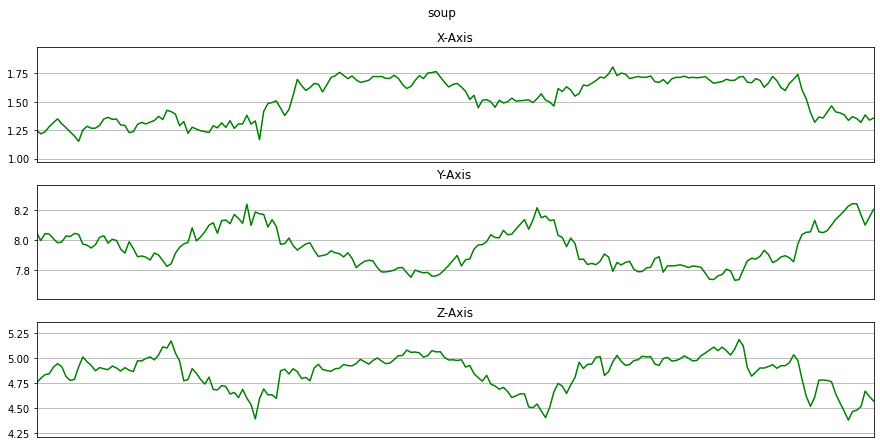

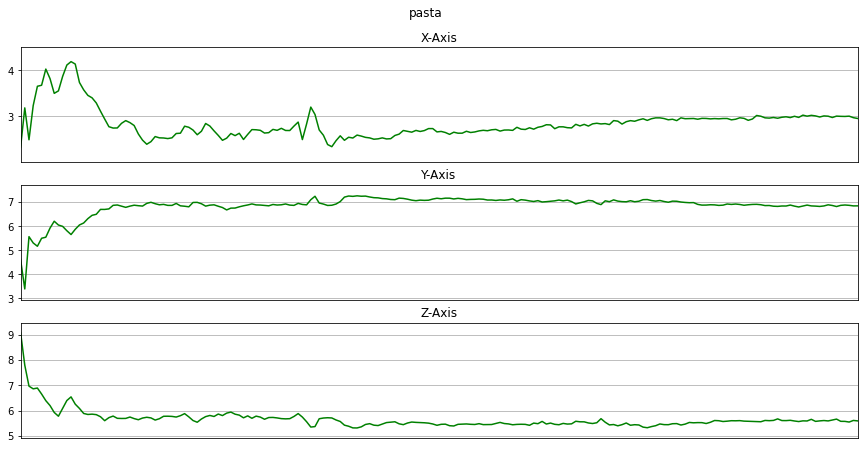

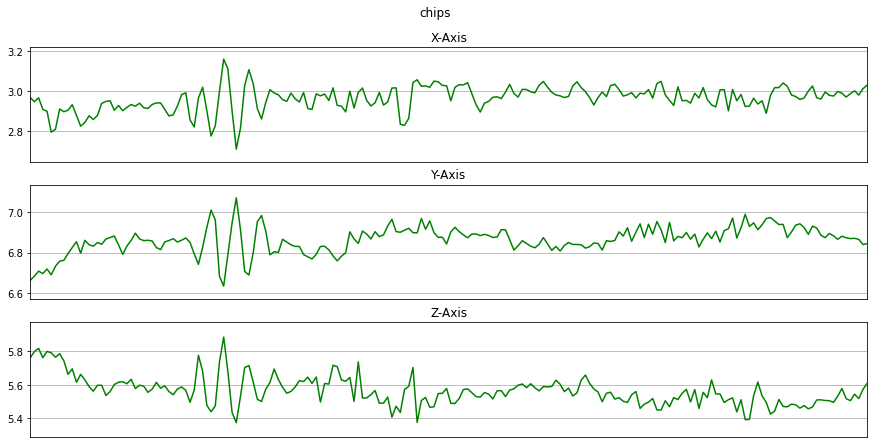

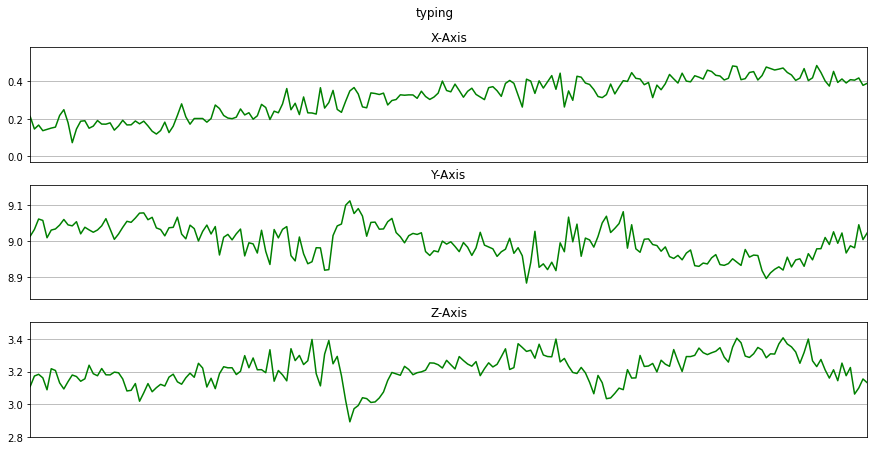

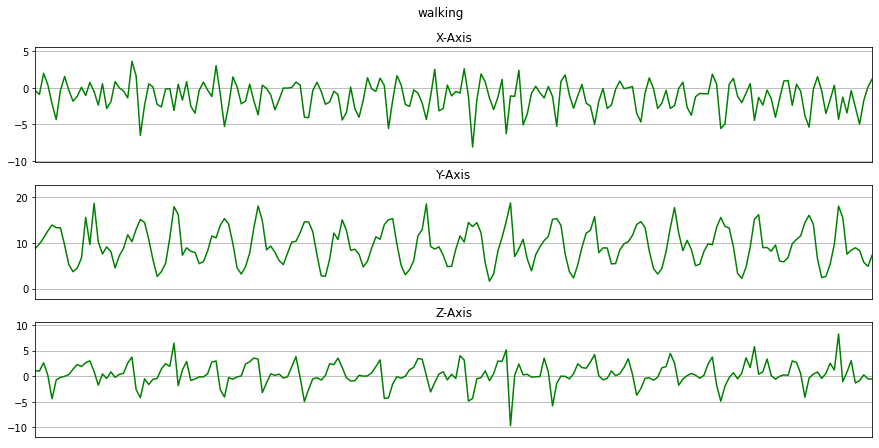

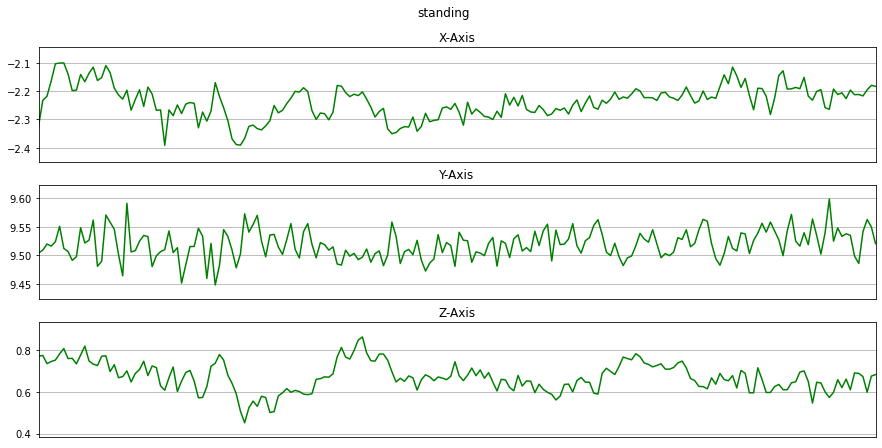

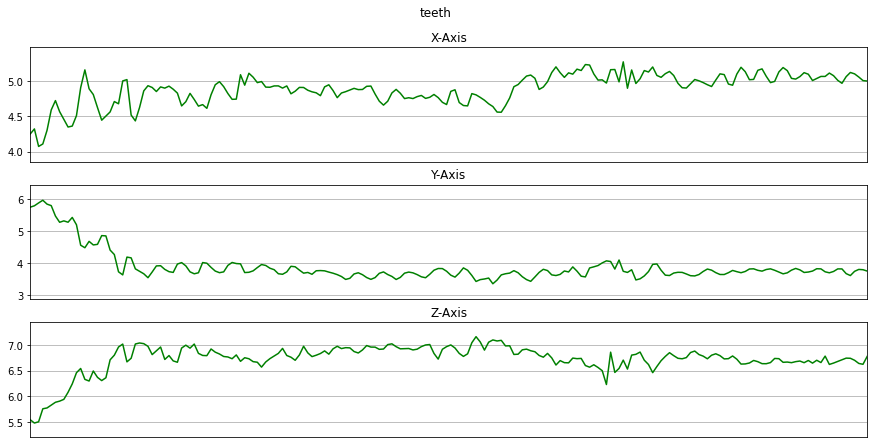

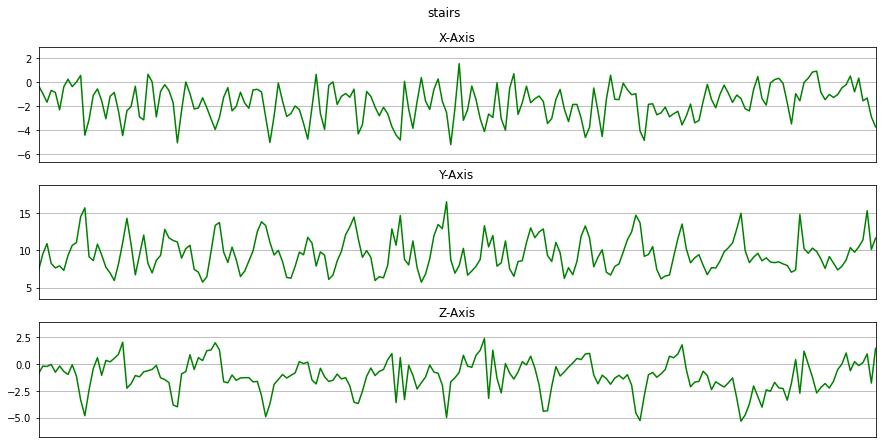

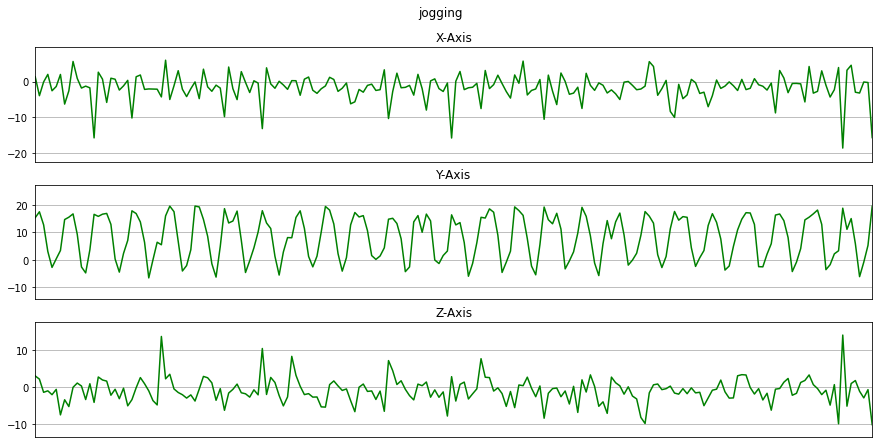

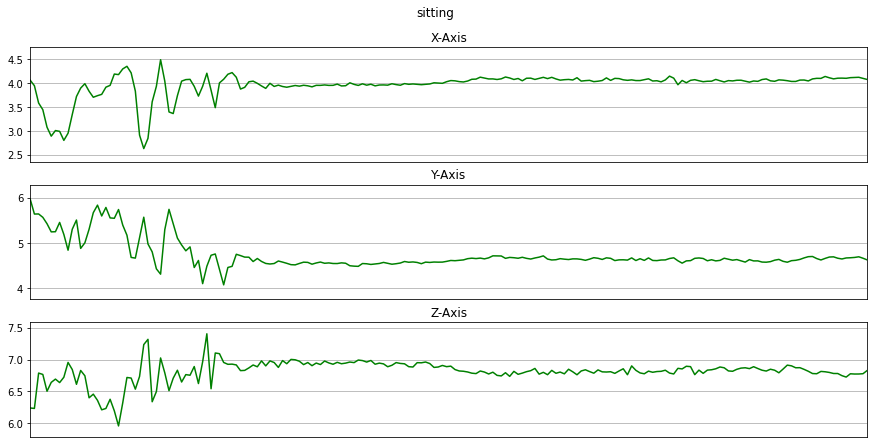

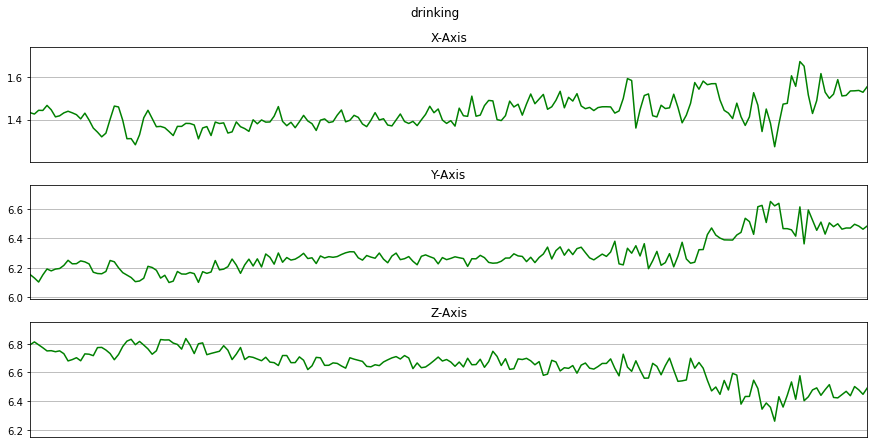

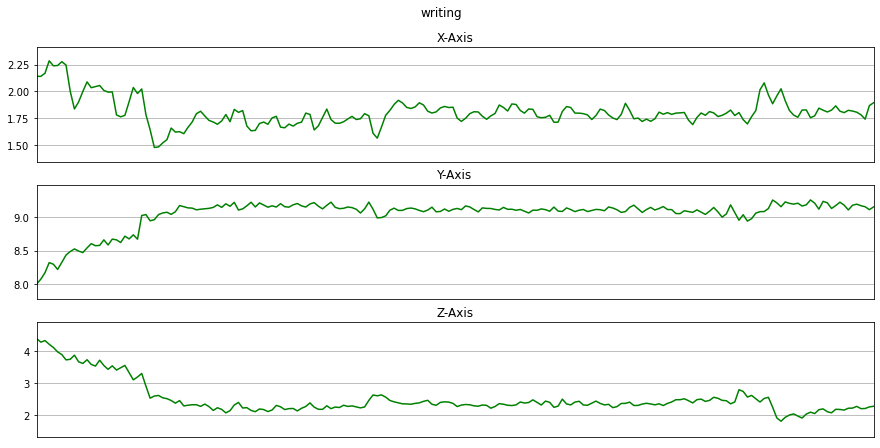

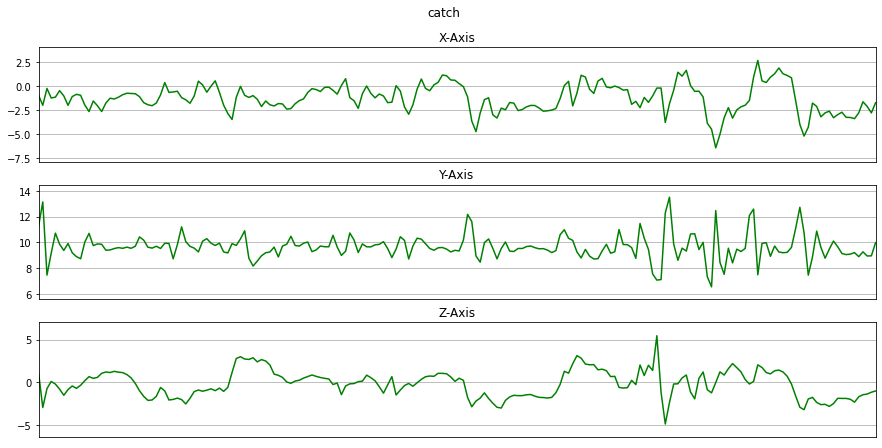

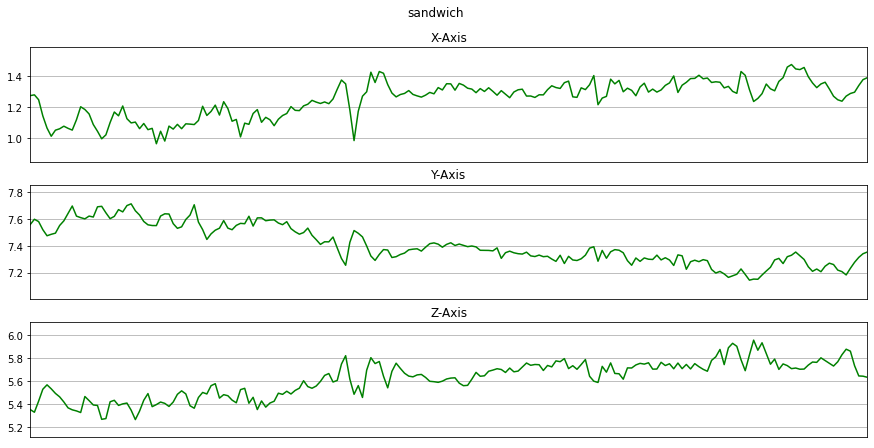

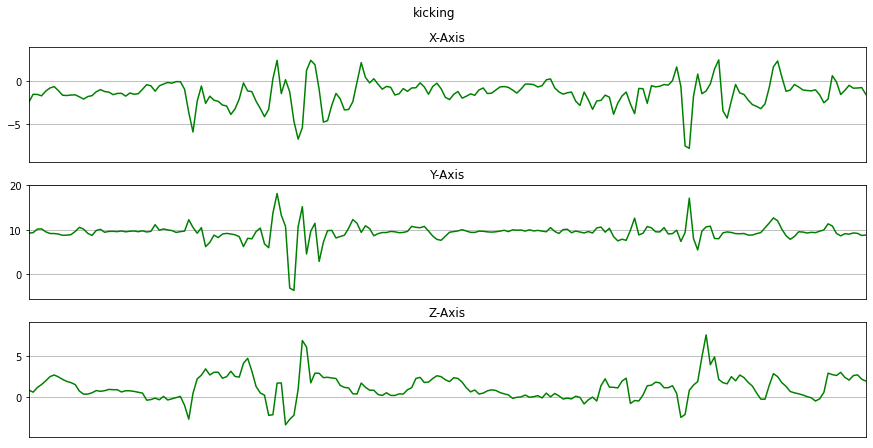

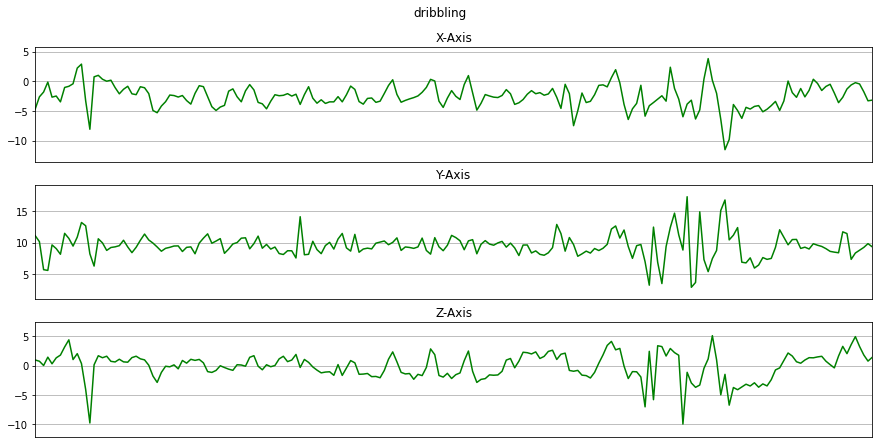

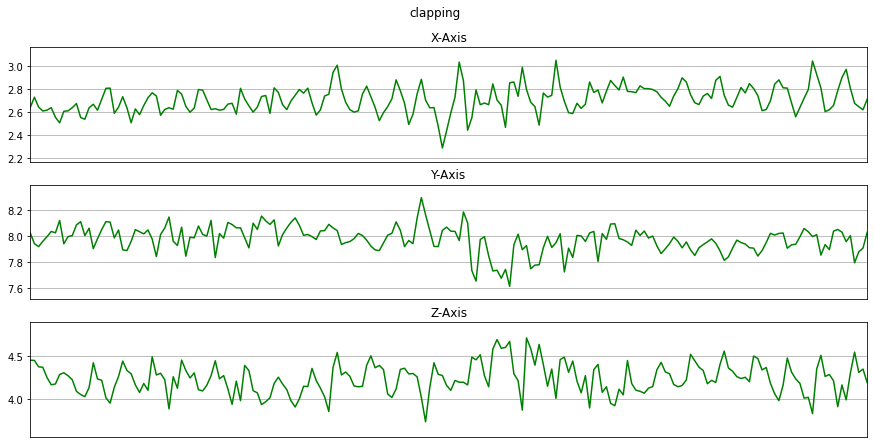

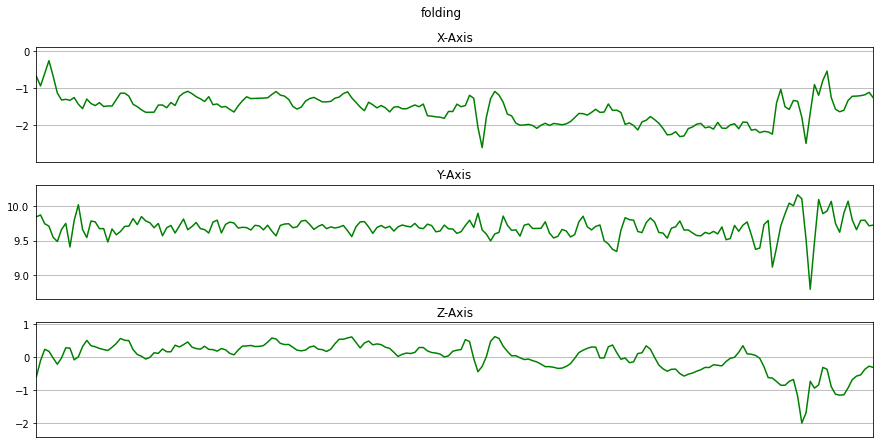

In [24]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [25]:
label = LabelEncoder()
data['label'] = label.fit_transform(data['activity'])
data.head()

,Unnamed: 0,user,activity,timestamp,x-axis,y-axis,z-axis,x,y,z,label
0,0,1600.0,walking,2.522077e+14,-0.364761,8.793503,1.055084,-0.364761,8.793503,1.055084,16
1,1,1600.0,walking,2.522077e+14,-0.879730,9.768784,1.016998,-0.879730,9.768784,1.016998,16
2,2,1600.0,walking,2.522078e+14,2.001495,11.109070,2.619156,2.001495,11.109070,2.619156,16
3,3,1600.0,walking,2.522078e+14,0.450623,12.651642,0.184555,0.450623,12.651642,0.184555,16
4,4,1600.0,walking,2.522079e+14,-2.164352,13.928436,-4.422485,-2.164352,13.928436,-4.422485,16


In [26]:
X = data[['x', 'y', 'z']]
y = data['label']

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X.head()

,x,y,z,label
0,0.115436,0.858229,-0.807686,16
1,-0.040964,1.013617,-0.816298,16
2,0.834085,1.227161,-0.454036,16
3,0.363074,1.472934,-1.004521,16
4,-0.431113,1.676361,-2.046215,16


In [28]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [29]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels


In [30]:
X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

((4998, 80, 3), (4998,))

In [31]:
y = np_utils.to_categorical(y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [33]:
X_train.shape, X_test.shape

((3998, 80, 3), (1000, 80, 3))

In [34]:
X_train = X_train.reshape(3998, 80, 3, 1)
X_test = X_test.reshape(1000, 80, 3, 1)

# Teacher Model

In [35]:
teacher_model = Sequential()
teacher_model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
teacher_model.add(Dropout(0.1))

teacher_model.add(Conv2D(32, (2, 2), activation='relu'))
teacher_model.add(Dropout(0.2))

teacher_model.add(Flatten())

teacher_model.add(Dense(64, activation = 'relu'))
teacher_model.add(Dropout(0.5))

teacher_model.add(Dense(128, activation = 'relu'))
teacher_model.add(Dropout(0.4))

teacher_model.add(Dense(18, activation='softmax'))

teacher_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 79, 2, 16)         80        
                                                                 
 dropout (Dropout)           (None, 79, 2, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 1, 32)         2080      
                                                                 
 dropout_1 (Dropout)         (None, 78, 1, 32)         0         
                                                                 
 flatten (Flatten)           (None, 2496)              0         
                                                                 
 dense (Dense)               (None, 64)                159808    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [36]:
teacher_model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = teacher_model.fit(X_train, y_train, epochs = 50, validation_data= (X_test, y_test), verbose=1)

Epoch 1/50
125/125 [==============================] - 6s 25ms/step - loss: 2.3304 - accuracy: 0.2074 - val_loss: 1.6811 - val_accuracy: 0.3730
Epoch 2/50
125/125 [==============================] - 2s 18ms/step - loss: 1.8325 - accuracy: 0.3167 - val_loss: 1.3878 - val_accuracy: 0.4440
Epoch 3/50
125/125 [==============================] - 3s 20ms/step - loss: 1.5629 - accuracy: 0.4010 - val_loss: 1.1391 - val_accuracy: 0.5760
Epoch 4/50
125/125 [==============================] - 2s 17ms/step - loss: 1.3851 - accuracy: 0.4632 - val_loss: 0.9706 - val_accuracy: 0.5940
Epoch 5/50
125/125 [==============================] - 2s 17ms/step - loss: 1.2480 - accuracy: 0.5073 - val_loss: 0.8963 - val_accuracy: 0.6460
Epoch 6/50
125/125 [==============================] - 2s 17ms/step - loss: 1.1391 - accuracy: 0.5453 - val_loss: 0.7793 - val_accuracy: 0.7360
Epoch 7/50
125/125 [==============================] - 2s 15ms/step - loss: 1.0360 - accuracy: 0.5845 - val_loss: 0.6550 - val_accuracy: 0.7610

# Student Model

In [37]:
# define the knowledge distillation loss
def kd_loss(y_true, y_pred, alpha=0.5):
    T = 2.0
    soft_target = K.softmax(y_true / T)
    return alpha * K.categorical_crossentropy(y_true, y_pred) + (1 - alpha) * K.categorical_crossentropy(soft_target, y_pred)

In [38]:
student_model = Sequential()
student_model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
student_model.add(Dropout(0.1))

student_model.add(Flatten())

student_model.add(Dense(64, activation = 'relu'))
student_model.add(Dropout(0.4))

student_model.add(Dense(18, activation='softmax'))
student_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 79, 2, 16)         80        
                                                                 
 dropout_4 (Dropout)         (None, 79, 2, 16)         0         
                                                                 
 flatten_1 (Flatten)         (None, 2528)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                161856    
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 18)                1170      
                                                                 
Total params: 163,106
Trainable params: 163,106
Non-tr

In [39]:
student_model.compile(optimizer=Adam(learning_rate = 0.01) , loss= kd_loss, metrics=['accuracy'])

history_student = student_model.fit(X_train, teacher_model.predict(X_train), epochs=50, batch_size=32, validation_data=(X_test, teacher_model.predict(X_test)))

32/32 [==============================] - 0s 5ms/step
Epoch 1/50
125/125 [==============================] - 4s 16ms/step - loss: 2.7257 - accuracy: 0.2401 - val_loss: 2.5976 - val_accuracy: 0.3830
Epoch 2/50
125/125 [==============================] - 1s 11ms/step - loss: 2.6154 - accuracy: 0.3469 - val_loss: 2.5012 - val_accuracy: 0.5650
Epoch 3/50
125/125 [==============================] - 2s 12ms/step - loss: 2.5689 - accuracy: 0.4135 - val_loss: 2.4785 - val_accuracy: 0.5810
Epoch 4/50
125/125 [==============================] - 1s 12ms/step - loss: 2.5457 - accuracy: 0.4517 - val_loss: 2.4535 - val_accuracy: 0.6340
Epoch 5/50
125/125 [==============================] - 1s 12ms/step - loss: 2.5394 - accuracy: 0.4657 - val_loss: 2.4330 - val_accuracy: 0.7270
Epoch 6/50
125/125 [==============================] - 1s 12ms/step - loss: 2.5185 - accuracy: 0.4857 - val_loss: 2.4063 - val_accuracy: 0.6840
Epoch 7/50
125/125 [==============================] - 2s 12ms/step - loss: 2.5099 - accur

# Model Evaluation of Teacher Model

In [40]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

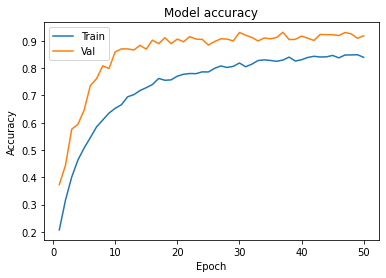

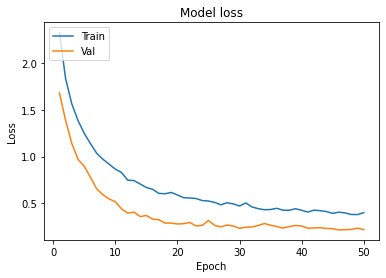

In [41]:
plot_learningCurve(history, 50)

In [42]:
y_pred = teacher_model.predict(X_test)

32/32 [==============================] - 0s 4ms/step


In [43]:
# Make predictions on the test data
probabilities = teacher_model.predict(X_test)
predictions = np.argmax(probabilities, axis=1)
predictions = np_utils.to_categorical(predictions)

# Obtain class labels
classes = [activity_map[key] for key in activity_map.keys()]

# Get the classification report
print(classification_report(y_test, predictions, target_names=classes))


32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     walking       0.79      0.55      0.65        40
     jogging       0.98      0.80      0.88        80
      stairs       1.00      1.00      1.00        40
     sitting       0.93      0.93      0.93        41
    standing       0.79      1.00      0.88        57
      typing       0.66      0.82      0.73        40
       teeth       0.97      1.00      0.98        58
        soup       0.82      0.82      0.82        40
       chips       0.82      0.97      0.89        86
       pasta       0.93      0.65      0.76        40
    drinking       1.00      1.00      1.00        58
    sandwich       0.99      0.98      0.98        85
     kicking       0.98      0.97      0.97        59
       catch       0.92      0.95      0.93        58
   dribbling       1.00      0.98      0.99        59
     writing       0.97      0.98      0.97        59
    clapping       0.96     

# Model Evaluation of Student Model

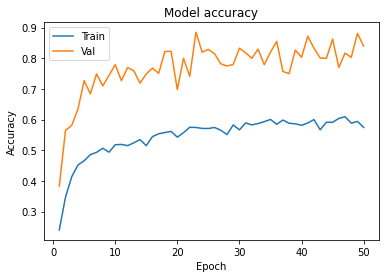

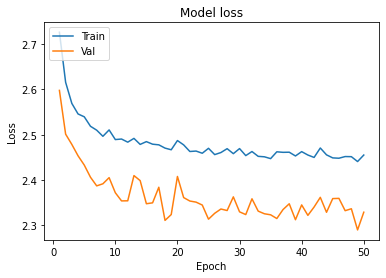

In [44]:
plot_learningCurve(history_student, 50)

In [45]:
y_pred2 = student_model.predict(X_test)

32/32 [==============================] - 0s 3ms/step


In [46]:
# Make predictions on the test data
probabilities1 = student_model.predict(X_test)
predictions1 = np.argmax(probabilities1, axis=1)
predictions1 = np_utils.to_categorical(predictions1)


# Get the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions1, target_names=classes))

32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     walking       0.61      0.68      0.64        40
     jogging       0.90      0.75      0.82        80
      stairs       0.98      1.00      0.99        40
     sitting       0.72      0.80      0.76        41
    standing       1.00      0.68      0.81        57
      typing       0.48      0.60      0.53        40
       teeth       0.92      1.00      0.96        58
        soup       0.88      0.57      0.70        40
       chips       0.77      0.98      0.86        86
       pasta       0.71      0.97      0.82        40
    drinking       0.75      0.97      0.84        58
    sandwich       0.94      0.94      0.94        85
     kicking       0.84      0.78      0.81        59
       catch       0.96      0.78      0.86        58
   dribbling       0.93      0.63      0.75        59
     writing       0.98      0.95      0.97        59
    clapping       0.81     